In [2]:
import numpy as np
import io
import os
import pandas as pd
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
import bdsg
import copy
import re 
import matplotlib.pyplot as plt
from collections import Counter

# Tests

In [3]:
### test chi deux ###
f_exp = np.array([44, 24, 29, 3]) / 100 * 189
f_obs = np.array([43, 52, 54, 40])
print("chi deux : ", chisquare(f_obs=f_obs, f_exp=f_exp))

chi deux :  Power_divergenceResult(statistic=228.23515947653874, pvalue=3.3295585338846486e-49)


In [4]:
### test exact fisher ###
table = np.array([[6, 2], [1, 4]])
M = table.sum()
n = table[0].sum()
N = table[:, 0].sum()
start, end = hypergeom.support(M, n, N)
hypergeom.pmf(np.arange(start, end + 1), M, n, N)
np.array([0.01631702, 0.16317016, 0.40792541, 0.32634033, 0.08158508,
       0.004662])
res = fisher_exact(table, alternative='two-sided')
print("fisher : ", res.pvalue)

fisher :  0.10256410256410256


# VCF

In [5]:
# on va essayer de faire un giga tableau qui recense tous les chemins possibles -> OK (pour un éch mais normalement c'est les mêmes chemins possibles)
# une fois qu'on aura fait ce giga tableau, on va essayer de le transformer en giga matrice qui compte pour 1 éch les chemins pris -> OK
# une fois que ce sera fait on pourra transformer la giga matrice en giga table de contingence (?) qui recense la même chose mais pour tous les échantillons -> OK (dataframe)

In [6]:
# fonctions annexes pour créer le df qui contient les infos après avoir parse tous les vcf

In [7]:
# read ONE vcf file

def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

# verification de la fonction read_vcf 

vcf1_df = read_vcf("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/samp_g0_0.vcf")
vcf1_df.head(n = 110)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,ref,450,>1>4,T,G,133.927,PASS,"AT=>1>2>4,>1>3>4;DP=46",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:46:46,0:-2.378747,-15.294357,-107.194421:1..."
1,ref,578,>4>9,TTTGCGGGCCGTCAAGATGAACTGGTGCCTGTAGGATTATGTCCTC...,TTTGCGGGCCGTCAAGATGAACTGGTGCCTGTAGGATTATGTCCTC...,14.6171,PASS,"AT=>4>5>7>8>9,>4>5>6>8>9;DP=50",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/0:50:25,25:-3.306431,-2.422690,-3.306431:16:..."
2,ref,1118,>9>12,A,G,177.783,PASS,"AT=>9>11>12,>9>10>12;DP=61",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:61:61,0:-2.701171,-20.002352,-141.869830:1..."
3,ref,1340,>12>14,GATCGGACTTCTTAACGGGTTCCTCACGTAGCGATCTCTACGGGAA...,G,116.981,PASS,"AT=>12>13>14,>12>14;DP=47",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:47:46,1:-2.770745,-13.991746,-90.540504:11..."
4,ref,1529,>14>19,C,CCCGATCTATGTCGAGGCTTTCGGGCAGGGCCGCTATTAACATCGT...,175.5,PASS,"AT=>14>19,>14>15>17>18>19,>14>15>16>18>19;DP=60",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:60:60,0,0:-2.835631,-19.908524,-19.908524,..."
...,...,...,...,...,...,...,...,...,...,...
95,ref,27003,>489>492,C,T,411.605,PASS,"AT=>489>490>492,>489>491>492;DP=43",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/0:43:20,23:-43.061833,-2.378411,-35.907321:2..."
96,ref,27134,>492>497,A,ATACACTAGACGCCCGGGATGTACATATCGTGACTCGTTCCTAGTC...,145.789,PASS,"AT=>492>497,>492>493>495>496>497,>492>493>494>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:50:50,0,0:-2.439843,-16.541658,-16.541658,..."
97,ref,27275,>497>502,TGCAATAGTTTGCTCGTGGTCAGTATTTTCGGTATAAAACAGAGTT...,"T,TGCAATAGTTTGCTCGTGGTCAGTATTTTCGGTATAAAACAGAG...",371.786,PASS,"AT=>497>498>500>501>502,>497>502,>497>498>499>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/2:52:2,24,27:-39.603567,-3.504039,-35.913027..."
98,ref,27745,>502>507,CGGACATGTAGCAGGACTCCTTATAGTTAATGTTCACTATTTAAAG...,CGGACATGTAGCAGGACTCCTTATAGTTAATGTTCACTATTTAAAG...,122.081,PASS,"AT=>502>503>504>506>507,>502>503>505>506>507,>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:42:42,0,0:-2.420888,-14.151905,-14.151905,..."


In [8]:
def chemins(vcf_df):    
    chemins_possibles = []
    for i in range(len(vcf_df["INFO"])):
        text = vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', text)
        if m:
            found = m.group(1)
        chemins_possibles.append(found)
        
    for i in range(len(chemins_possibles)):
        chemins_possibles[i] = chemins_possibles[i].split(',')
        
    ########################################################################
    chemins_pris = []
    for i in vcf_df["SAMPLE"]:
        found = i[0:3]
        chemins_pris.append(found)
    
    for i in range(len(chemins_pris)):
        chemins_pris[i] = chemins_pris[i].split('/')
        for j in range(len(chemins_pris[i])):
            chemins_pris[i][j] = int(chemins_pris[i][j])
            
    ########################################################################
    chemins_combines = copy.deepcopy(chemins_pris)
    
    for i in range(len(chemins_pris)):
        chemins_combines[i][0] = chemins_possibles[i][chemins_pris[i][0]]
        chemins_combines[i][1] = chemins_possibles[i][chemins_pris[i][1]]
        
    ''' cas simple pour comprendre
    print(chemins_pris[0])
    chemins_pris[0][0] = chemins_possibles[0][chemins_pris[0][0]]
    chemins_pris[0][1] = chemins_possibles[0][chemins_pris[0][1]]
    print(chemins_pris[0])'''
    
    chemins_possibles = sum(chemins_possibles, [])
    chemins_pris = sum(chemins_pris, [])
    chemins_combines = sum(chemins_combines, [])
    
    return chemins_possibles, chemins_pris, chemins_combines

In [9]:
# verification de la fonction chemins

chemins_possibles1, chemins_pris1, chemins_combines1 = chemins(vcf1_df)
print('========== possibles ==========')
print(chemins_possibles1[0:5])
print('============ pris =============')
print(chemins_pris1[0:5])
print('========== combinés ===========')
print(chemins_combines1[0:5])

========== possibles ==========
['1>2>4', '>1>3>4', '4>5>7>8>9', '>4>5>6>8>9', '9>11>12']
============ pris =============
[0, 0, 1, 0, 0]
========== combinés ===========
['1>2>4', '1>2>4', '>4>5>6>8>9', '4>5>7>8>9', '9>11>12']


In [10]:
def times_taken(chemins_possibles, chemins_pris, chemins_combines, df):    
    combine_count = list((x,chemins_combines.count(x)) for x in set(chemins_combines))
    for i in range(len(combine_count)):
        for j in range(len(chemins_pris)):
            if combine_count[i][0] == str(df['snarl'][j]):
                df.loc[j, "times taken"] += combine_count[i][1]

In [11]:
#commentaires bizarres je sais pas où les placer

# on refait la même chose mais pour tous les VCF 
# création d'un df avec autant de lignes que de fichiers VCF 
# et mtn qu'on a un tout beau data frame on peut faire tout pareil mais en parsant tous les VCF :D 
# on refait pareil mais en séparant les groupes g0 et g1

In [12]:
# read all vcf files and store them in a list

all_vcf = os.listdir("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/")
g0_vcf =  []
g1_vcf = []
for i in all_vcf:
    if 'g0' in i:
        g0_vcf.append(i)
    elif 'g1' in i:
        g1_vcf.append(i)

In [13]:
def create_df(which_vcf_list):
    df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken'])
    df['snarl'] = chemins_possibles1 
    df['times taken'] = 0
    
    # fill 'snarl index' column
    for i in range(len(df['snarl index'])):
        if df['snarl'][i][0] == '>':
            S = re.search('>(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e    
        else:
            S = re.search('(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e
    
            
    # fill 'times taken' column
    for i in which_vcf_list:
        vcf_df = read_vcf("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"+i)
        chemins_possibles, chemins_pris, chemins_combines = chemins(vcf_df)
        times_taken(chemins_possibles, chemins_pris, chemins_combines, df)
    
    df.set_index('snarl index', inplace=True, drop=True)
    return df

In [14]:
# complete df
snarl_df = create_df(all_vcf)
snarl_df.tail(n=5)

,snarl,times taken
snarl index,,
502>507,>502>503>505>506>507,0
502>507,>502>507,0
507>512,507>512,0
507>512,>507>508>509>511>512,0
507>512,>507>508>510>511>512,0


In [15]:
# group0 df
g0_df = create_df(g0_vcf)
g0_df.head(n=20)

,snarl,times taken
snarl index,,
1>4,1>2>4,27
1>4,>1>3>4,33
4>9,4>5>7>8>9,23
4>9,>4>5>6>8>9,32
9>12,9>11>12,54
9>12,>9>10>12,6
12>14,12>13>14,43
12>14,>12>14,17
14>19,14>19,36


In [16]:
# group1 df
g1_df = create_df(g1_vcf)
g1_df.tail(n=5)

,snarl,times taken
snarl index,,
502>507,>502>503>505>506>507,0
502>507,>502>507,0
507>512,507>512,0
507>512,>507>508>509>511>512,0
507>512,>507>508>510>511>512,0


In [18]:
# mtn on utilise g0_df et g1_df pour créer des tables de contingences (en précisant pour quel snarl on veut créer la table)

def table_contingence(which_snarl):
    n = snarl_df.index.value_counts()[which_snarl]
    '''if n == 2:
        thing1 = g0_df.loc[which_snarl]['snarl'][0]
        thing2 = g0_df.loc[which_snarl]['snarl'][1]
        
        df2 = pd.DataFrame(columns=['g0', 'g1'], index=[thing1, thing2])
        
        df2.at[thing1, 'g0'] = g0_df.loc[which_snarl]['times taken'][0]
        df2.at[thing2, 'g0'] = g0_df.loc[which_snarl]['times taken'][1]
        df2.at[thing1, 'g1'] = g1_df.loc[which_snarl]['times taken'][0]
        df2.at[thing2, 'g1'] = g1_df.loc[which_snarl]['times taken'][1]
    else:'''
    thing = []
    for i in range(n):
        thing.append(g0_df.loc[which_snarl]['snarl'].iloc[i])
        #thing.append(g0_df.loc[which_snarl]['snarl'][i])
        # corpus_df.loc['it'][1]
    df2 = pd.DataFrame(columns=['g0', 'g1'], index=thing)
    for i in range(len(thing)):
        df2.at[thing[i], 'g1'] = g1_df.loc[which_snarl]['times taken'].iloc[i]
        df2.at[thing[i], 'g0'] = g0_df.loc[which_snarl]['times taken'].iloc[i]
    return df2


In [19]:
# je l'utilise pas
def zero_in_table(table):
    return 0 in table.values

In [20]:
def chi2(table):
    return chi2_contingency(table).pvalue

In [45]:
pval = []
snarl_pb = []
for i in snarl_df.index.unique():
    if not 0 in table_contingence(i).values:
        #print(i)
        #table = table_contingence(i)
        pval.append(chi2(table_contingence(i)))
        #print(i, 'ok')
    else:
        pval.append(0)
        snarl_pb.append(i)
print(snarl_pb)

['111>116', '136>147', '152>154', '159>170', '204>239', '315>329', '351>380', '380>403', '466>471', '471>473', '473>475', '475>478', '478>481', '481>486', '486>489', '489>492', '492>497', '497>502', '502>507', '507>512']


(array([ 9., 10.,  4.,  4.,  7.,  7.,  4.,  7.,  6., 22.]),
 array([8.12903173e-07, 1.00000732e-01, 2.00000650e-01, 3.00000569e-01,
        4.00000488e-01, 5.00000406e-01, 6.00000325e-01, 7.00000244e-01,
        8.00000163e-01, 9.00000081e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

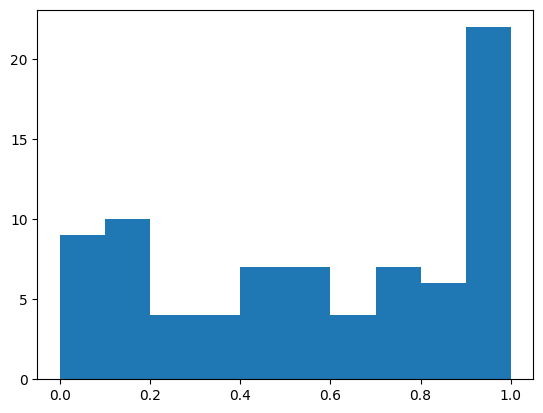

In [23]:
plt.hist(pval)

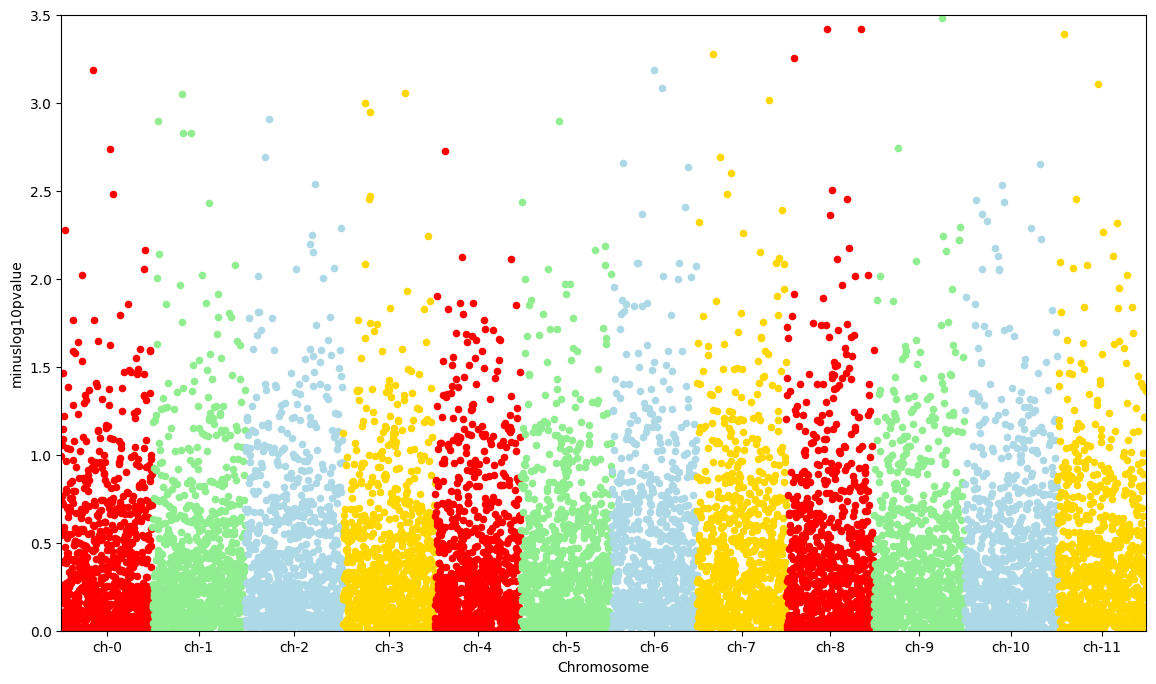

In [83]:
from pandas import DataFrame
from scipy.stats import uniform
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt

# sample data
df = DataFrame({'gene' : ['gene-%i' % i for i in np.arange(10000)],
'pvalue' : uniform.rvs(size=10000),
'chromosome' : ['ch-%i' % i for i in randint.rvs(0,12,size=10000)]})

# -log_10(pvalue)
df['minuslog10pvalue'] = -np.log10(df.pvalue)
df.chromosome = df.chromosome.astype('category')
df.chromosome = df.chromosome.cat.set_categories(['ch-%i' % i for i in range(12)], ordered=True)
df = df.sort_values('chromosome')

# How to plot gene vs. -log10(pvalue) and colour it by chromosome?
df['ind'] = range(len(df))
df_grouped = df.groupby(('chromosome'), observed = False)

# manhattan plot
fig = plt.figure(figsize=(14, 8)) # Set the figure size
ax = fig.add_subplot(111)
colors = ['red','lightgreen','lightblue', 'gold']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)], ax=ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)

# set axis limits
ax.set_xlim([0, len(df)])
ax.set_ylim([0, 3.5])

# x axis label
ax.set_xlabel('Chromosome')

# show the graph
plt.show()

/home/yboulkaid/PycharmProjects/premiers_tests/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


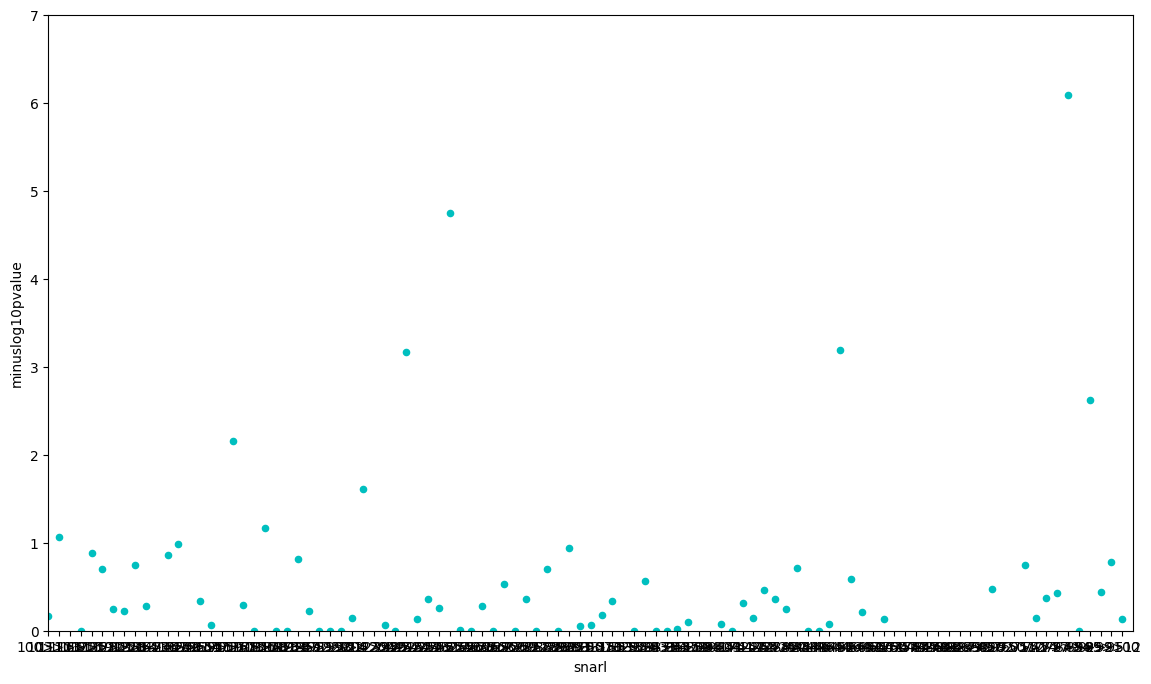

In [98]:
from pandas import DataFrame
from scipy.stats import uniform
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt

# sample data
df = DataFrame({'pvalue' : pval,
'snarl' : snarl_df.index.unique()})

# -log_10(pvalue)
df['minuslog10pvalue'] = -np.log10(df.pvalue)
df.snarl = df.snarl.astype('category')
df = df.sort_values('snarl')

# How to plot gene vs. -log10(pvalue) and colour it by chromosome?
df['ind'] = range(len(df))
df_grouped = df.groupby(('snarl'), observed = False)

df['c'] = np.where(df['minuslog10pvalue']>1.5, 'lightgreen', 'red')
'''conditions = [
    (df['minuslog10pvalue'] == np.inf),
    (df['minuslog10pvalue'] > 1.5),
    (df['minuslog10pvalue'] < 1.5)]
choices = ['red', 'green', 'purple']
df['color'] = np.select(conditions, choices, default='red')'''

# manhattan plot
fig = plt.figure(figsize=(14, 8)) # Set the figure size
ax = fig.add_subplot(111)
# colors = ['red','lightgreen','lightblue', 'gold']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='minuslog10pvalue', color='c', ax=ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)

# set axis limits
ax.set_xlim([0, len(df)])
ax.set_ylim([0, 7])

# x axis label
ax.set_xlabel('snarl')

# show the graph
plt.show()

In [88]:
df

,pvalue,snarl,minuslog10pvalue,ind,c
24,0.676602,100>103,0.169667,0,red
25,0.086197,103>111,1.064508,1,red
26,0.000000,111>116,inf,2,lightgreen
27,1.000000,116>119,-0.000000,3,red
28,0.131428,119>122,0.881312,4,red
...,...,...,...,...,...
20,1.000000,84>89,-0.000000,95,red
21,0.002376,89>92,2.624205,96,lightgreen
22,0.360241,92>95,0.443407,97,red
23,0.165728,95>100,0.780604,98,red


In [101]:
big_pval = []
big_snarl = []
for i in range(len(df)):
    if df['minuslog10pvalue'].iloc[i] > 2 and df['minuslog10pvalue'].iloc[i] != np.inf:
        big_pval.append(df['minuslog10pvalue'].iloc[i])
        big_snarl.append(df['snarl'].iloc[i])

print(big_pval)
print(big_snarl)

for i in range(len(big_snarl)):
    print('##########', big_pval[i])
    print(table_contingence(big_snarl[i]))
    

[2.15176597063122, 3.1620872897202483, 4.743716244978902, 3.1902936329226557, 6.089961181235811, 2.624205309601664]
['170>173', '242>245', '254>256', '446>449', '79>84', '89>92']
########## 2.15176597063122
              g0  g1
170>171>173   56  44
>170>172>173   4  16
########## 3.1620872897202483
              g0  g1
242>243>245   47  28
>242>244>245  13  32
########## 4.743716244978902
             g0  g1
254>255>256  52  29
>254>256      8  31
########## 3.1902936329226557
              g0  g1
446>448>449   54  37
>446>447>449   6  23
########## 6.089961181235811
                g0  g1
79>80>81>83>84  15  43
>79>84          45  17
########## 2.624205309601664
           g0  g1
89>91>92   35  51
>89>90>92  25   9


 # 'Play' with bdsg
##### am i playing with bdsg or is bdsg playing with me

In [ ]:
from bdsg.bdsg import HashGraph

gr = HashGraph()
seq = ["CGA", "TTGG", "CCGT", "C", "GT", "GATAA", "CGG", "ACA", "GCCG", "ATATAAC"]
n = []
for s in seq:
    n.append(gr.create_handle(s))

gr.create_edge(n[0], n[1])
gr.create_edge(n[1], n[2])
gr.create_edge(n[2], n[3])
gr.create_edge(n[2], n[4])
gr.create_edge(n[3], n[5])
gr.create_edge(n[5], n[6])
# Connect the end of n5 to the start of n8
gr.create_edge(n[5], n[8])
gr.create_edge(n[6], n[7])
gr.create_edge(n[6], n[8])
gr.create_edge(n[7], n[9])
gr.create_edge(n[8], n[9])
# Connect the end of n8 back around to the start of n5
gr.create_edge(n[8], n[5])

def next_node_list(handle):
    lis = []
    gr.follow_edges(handle, False, lambda y: lis.append(y))
    return lis

print(f'n0: {gr.get_sequence(n[0])}')
next_node = next_node_list(n[0])[0]
print(f'n1: {gr.get_sequence(next_node)}')
next_node = next_node_list(next_node)[0]
print(f'n2: {gr.get_sequence(next_node)}')

path = gr.create_path_handle("path")
gr.append_step(path, n[0])
gr.append_step(path, n[1])
gr.append_step(path, n[2])
gr.append_step(path, n[4])
gr.append_step(path, n[5])
gr.append_step(path, n[6])
gr.append_step(path, n[7])
gr.append_step(path, n[9])

In [ ]:
from bdsg.bdsg import PackedGraph
brca2 = PackedGraph()
brca2.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.pg")
#brca2.deserialize("/home/yboulkaid/Téléchargements/cactus-brca2.pg")

path_handle = []
handles = []
brca2.for_each_path_handle(lambda y: path_handle.append(y) or True)
brca2.for_each_step_in_path(path_handle[0],
    lambda y: handles.append(brca2.get_handle_of_step(y)) or True)
sequence = ""
for handle in handles:
    sequence += brca2.get_sequence(handle)
print(sequence[0:10])
print(len(sequence))


In [ ]:
type(gr)

# CACGTCCGAGAATCGG
# CACGTCCGAG

In [ ]:
from bdsg.handlegraph import  HandleGraph
###########################################
### HOW TO ACCESS THE SNARL TREE (XIAN) ###
###########################################

#Load the distance index
distance_index = bdsg.bdsg.SnarlDistanceIndex()
distance_index.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.dist")

# net graph to build
ngraph = {'e': [], 'n': []}

# init with the child (only one ideally) of the root
root = distance_index.get_root() #Get a net handle referring to a tip-to-tip traversal of the contents of the root snarl.

def add_node_to_ngraph(net):
    ngraph['n'].append(net)
distance_index.for_each_child(root, add_node_to_ngraph)

distance_index.net_handle_as_string(ngraph['n'][0])

node3 = distance_index.get_node_net_handle(3)
parent3 = distance_index.get_parent(node3)
snarl_start_bound = distance_index.get_bound(parent3, False, True)

# for functions taking an iteratee
# print the net_handle_t and return true to continue iterating
def iterate (net) :
    print(distance_index.net_handle_as_string(net))
    return True

graph = HandleGraph()
#graph.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.pg")

print("Follow edges from", distance_index.net_handle_as_string(snarl_start_bound), ":" )
distance_index.follow_net_edges(snarl_start_bound, graph, False, iterate)


# graph: bdsg.handlegraph.HandleGraph

In [ ]:
print(ngraph)
print(distance_index.net_handle_as_string(ngraph['n'][0]))

In [ ]:
ngraph['n']

In [ ]:
distance_index.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.dist")

In [ ]:
'''get parent 
get child 
get bound 
get root'''